In [ ]:
!pip install pandas
!pip install tqdm
!pip install --upgrade tensorflow
!pip install --upgrade simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 98.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfull

**IMPORTS**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs

import logging

import matplotlib.pyplot as plt

import string
import re
from scipy.stats import pearsonr
import numpy as np
from sklearn.metrics import f1_score


In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. GPU is enabled.")
else:
    print("CUDA is not available. GPU is not enabled.")

CUDA is available. GPU is enabled.


In [ ]:
# Load the text file
df_train = pd.read_csv(f'EI-reg-En-anger-train (2).txt', delimiter='\t')

In [ ]:
df_test = pd.read_csv('2018-EI-reg-En-anger-test-gold (1).txt', delimiter='\t')

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1002 non-null   object 
 1   Tweet             1002 non-null   object 
 2   Affect Dimension  1002 non-null   object 
 3   Intensity Score   1002 non-null   float64
dtypes: float64(1), object(3)
memory usage: 31.4+ KB


In [ ]:
# Info about the dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1701 non-null   object 
 1   Tweet             1701 non-null   object 
 2   Affect Dimension  1701 non-null   object 
 3   Intensity Score   1701 non-null   float64
dtypes: float64(1), object(3)
memory usage: 53.3+ KB


In [ ]:
df_train.head()

,ID,Tweet,Affect Dimension,Intensity Score
0,2017-En-10264,@xandraaa5 @amayaallyn6 shut up hashtags are c...,anger,0.562
1,2017-En-10072,it makes me so fucking irate jesus. nobody is ...,anger,0.750
2,2017-En-11383,Lol Adam the Bull with his fake outrage...,anger,0.417
3,2017-En-11102,@THATSSHAWTYLO passed away early this morning ...,anger,0.354
4,2017-En-11506,@Kristiann1125 lol wow i was gonna say really?...,anger,0.438


In [ ]:
df_test.head()

,ID,Tweet,Affect Dimension,Intensity Score
0,2018-En-02328,@PageShhh1 I know you mean well but I'm offend...,anger,0.734
1,2018-En-02617,"Let go of resentment, it will hold you back, d...",anger,0.422
2,2018-En-01021,"No, I'm not 'depressed because of the weather,...",anger,0.663
3,2018-En-03737,#AmarnathTerrorAttack Muslims are killing eve...,anger,0.703
4,2018-En-03407,Prepare to suffer the sting of Ghost Rider's p...,anger,0.719


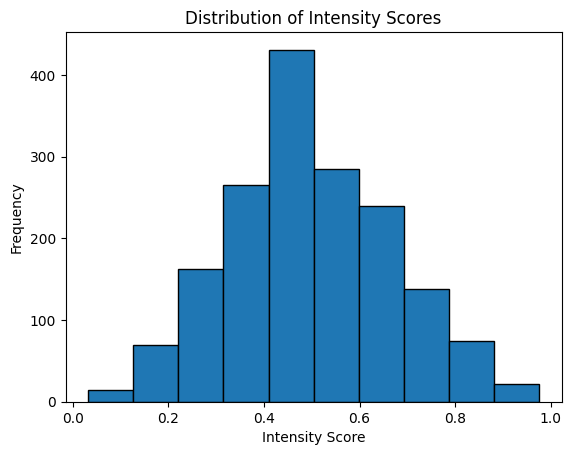

In [ ]:
# Create a histogram
plt.hist(df_train['Intensity Score'], bins=10, edgecolor='black')

# Add a title and labels
plt.title('Distribution of Intensity Scores')
plt.xlabel('Intensity Score')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

**PREPROCESSING**

In [ ]:
abbreviations = {
    "w/": "with",
    "w/o": "without",
    "msg": "message",
    "u": "you",
    "r": "are",
    "lol": "laughing out loud",
    "np": "no problem",
    "LOL": "laughing out loud",
    "XD" : "laugh",
    "xd" : "laugh"
}

# Define a function to correct abbreviations in a string
def correct_abbreviations(text, abbreviations):
    words = text.split()
    corrected_words = []
    for word in words:
        if word in abbreviations:
            corrected_word = abbreviations[word]
            corrected_words.append(corrected_word)
        else:
            corrected_words.append(word)
    corrected_text = ' '.join(corrected_words)
    return corrected_text

In [ ]:
def preprocess_tweets(tweet):
  # Convert all words to lower case
  tweet = tweet.lower()

  # Remove mentions
  tweet = re.sub(r'@\w+', '', tweet)

  # Remove all punctuations
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))

  # Remove numbers
  tweet = re.sub(r'\d+', '', tweet)

  # Correct Abbreviations
  tweet = correct_abbreviations(tweet, abbreviations)



  return tweet

In [ ]:
df_train["PreprocessedTweet"] = df_train["Tweet"].map(preprocess_tweets)

In [ ]:
df_train.head()

,ID,Tweet,Affect Dimension,Intensity Score,PreprocessedTweet
0,2017-En-10264,@xandraaa5 @amayaallyn6 shut up hashtags are c...,anger,0.562,shut up hashtags are cool offended
1,2017-En-10072,it makes me so fucking irate jesus. nobody is ...,anger,0.750,it makes me so fucking irate jesus nobody is c...
2,2017-En-11383,Lol Adam the Bull with his fake outrage...,anger,0.417,laughing out loud adam the bull with his fake ...
3,2017-En-11102,@THATSSHAWTYLO passed away early this morning ...,anger,0.354,passed away early this morning in a fast and f...
4,2017-En-11506,@Kristiann1125 lol wow i was gonna say really?...,anger,0.438,laughing out loud wow i was gonna say really h...


In [ ]:
df_t= df_train.drop(['Tweet','ID', 'Affect Dimension'],  axis=1)

df_train= df_t[["PreprocessedTweet","Intensity Score"]]
df_train.head()

,PreprocessedTweet,Intensity Score
0,shut up hashtags are cool offended,0.562
1,it makes me so fucking irate jesus nobody is c...,0.750
2,laughing out loud adam the bull with his fake ...,0.417
3,passed away early this morning in a fast and f...,0.354
4,laughing out loud wow i was gonna say really h...,0.438


In [ ]:
df_test = df_test[["Tweet","Intensity Score"]]

In [ ]:
df_test.head()

,Tweet,Intensity Score
0,@PageShhh1 I know you mean well but I'm offend...,0.734
1,"Let go of resentment, it will hold you back, d...",0.422
2,"No, I'm not 'depressed because of the weather,...",0.663
3,#AmarnathTerrorAttack Muslims are killing eve...,0.703
4,Prepare to suffer the sting of Ghost Rider's p...,0.719


In [ ]:

# Enabling regression
# Setting optional model configuration
model_args = ClassificationArgs()
model_args.num_train_epochs = 1
model_args.regression = True
model_args.overwrite_output_dir=True



# Create a ClassificationModel
model = ClassificationModel(
    "bertweet",
    "vinai/bertweet-base",
    num_labels=1,
    args=model_args,
    use_cuda=True

)

# Train the model
model.train_model(df_train)




config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1701 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/213 [00:00<?, ?it/s]

(213, 0.026070404906009495)

In [ ]:
predictions, raw_outputs = model.predict(df_test["Tweet"].tolist())

  0%|          | 0/1002 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

In [ ]:
# Compute the Pearson correlation coefficient
r, _ = pearsonr(df_test['Intensity Score'], predictions)
print('Pearson correlation:', r)

Pearson correlation: 0.7985392807716264
